# Analysis of Public Comments Regarding the EPA's Revised Definition of "Waters of the United States" (WOTUS)

In early 2017, President Trump signed an Executive Order<sup>[1](#footnote1)</sup> requesting that agencies review a 2015 rule regarding the "Waters of the United States". The agencies, including the Environmental Protection Agency (EPA) and the Department of the Army, were instructed to rescind or replace the rule, in accordance with law.

The agencies have since conducted a reevaluation and revision of the definition of "Waters of the United States". Their proposed rule redefines the scope of waters federally regulated under the Clean Water Act (CWA). This rule was open for public comment until April 15, 2019.

This project applies Natural Language Processing techniques to analyze the content of the comments that are publicly available in docket EPA-HQ-OW-2018-0149 on the [regulations.gov web page](https://www.regulations.gov/docket?D=EPA-HQ-OW-2018-0149). For technical reasons, the dataset only includes ~8K out of the listed ~11K comments, which represent ones that were typed directly onto the site. The dataset excludes ~3K comments that were submitted in an attachment form. Out of the collected comments, a sample of 1200 were manually labeled to reflect support (1) or opposition (0) to the rule change. Labeling the data was necessary to perform sentiment analysis.

The goals of this project are to:

- Apply unsupervised learning algorithms to better understand the underlying structure of the comments - are there distinct topics or clusters, or is there too much language overlap for the model to find meaningful distinctions?
- Determine if the performance of sentiment analysis models meets thresholds to be able to label the remainder of the (un-labeled) comments

Notes:

<a name="footnote1">1</a>: Executive Order 13778, signed on February 28, 2017, titled "Restoring the Rule of Law, Federalism, and Economic Growth by Reviewing the 'Waters of the United States' Rule"

## Library Imports

In [2]:
# Standard imports
import re
import sys
import warnings
warnings.filterwarnings('ignore', 'DeprecationWarning') 

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
# Model and analysis imports
from scipy import linalg

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import LatentDirichletAllocation as LDA, TruncatedSVD, NMF, PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import metrics
from sklearn.manifold import TSNE

import spacy

from wordcloud import WordCloud
import pyLDAvis.sklearn

In [4]:
# Un-comment and run cell to install spaCy and language model
# !conda install --yes --prefix {sys.prefix} spacy
# !{sys.executable} -m spacy download en_core_web_sm  # small language model
# !{sys.executable} -m spacy download en_core_web_lg  # large language model

In [5]:
# Un-comment and run cell to install pyLDAVis package
# !{sys.executable} -m pip install pyldavis

In [6]:
full_df = pd.read_pickle('./Data/full_labeled.pkl')

full_df.head()

,Document Title,Document ID,Posted Date,Received Date,Document SubType,Post Mark Date,Document Detail,Comment,Support_Rule_Change
0,Anonymous public comment,EPA-HQ-OW-2018-0149-6689,2019-04-29,2019-04-11,Public Comment,04/11/2019,https://www.regulations.gov/document?D=EPA-HQ-...,I write to express my opposition to the Enviro...,0.0
1,Anonymous public comment,EPA-HQ-OW-2018-0149-6688,2019-04-29,2019-04-11,Public Comment,04/11/2019,https://www.regulations.gov/document?D=EPA-HQ-...,I write to express my opposition to the Enviro...,0.0
2,Anonymous public comment,EPA-HQ-OW-2018-0149-7377,2019-05-01,2019-04-11,Public Comment,04/11/2019,https://www.regulations.gov/document?D=EPA-HQ-...,Please abandon this proposed rollback of the 2...,0.0
3,Anonymous public comment,EPA-HQ-OW-2018-0149-6707,2019-04-29,2019-04-11,Public Comment,04/11/2019,https://www.regulations.gov/document?D=EPA-HQ-...,"My husband and I have two wonderful daughters,...",0.0
4,Comment submitted by T. Dahlin,EPA-HQ-OW-2018-0149-7983,2019-05-01,2019-04-12,Public Comment,04/12/2019,https://www.regulations.gov/document?D=EPA-HQ-...,Please do not change the definitions within th...,0.0


In [7]:
# Segment comments and labels, drop duplicate comments, remove comment box artifacts
comments = full_df.loc[:, ['Comment', 'Support_Rule_Change']]
print(comments.loc[5993, 'Comment'])

comments.drop_duplicates(['Comment'], inplace=True)

comments['Comment'] = comments['Comment'].apply(lambda s: s.replace('PLEASE WRITE YOUR COMMENT HERE:', ''))
print(comments.loc[5993, 'Comment'])

PLEASE WRITE YOUR COMMENT HERE:  It is my wish and request that the Waters of the United States regulation be repealed. Regards, Thomas Moore
  It is my wish and request that the Waters of the United States regulation be repealed. Regards, Thomas Moore


In [8]:
comments.head()

,Comment,Support_Rule_Change
0,I write to express my opposition to the Enviro...,0.0
1,I write to express my opposition to the Enviro...,0.0
2,Please abandon this proposed rollback of the 2...,0.0
3,"My husband and I have two wonderful daughters,...",0.0
4,Please do not change the definitions within th...,0.0


In [9]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7986 entries, 0 to 8186
Data columns (total 2 columns):
Comment                7986 non-null object
Support_Rule_Change    1200 non-null float64
dtypes: float64(1), object(1)
memory usage: 507.2+ KB


In [10]:
# Fill unlabeled comments with -1
comments.fillna(value=-1, axis=1, inplace=True)
comments.tail()

,Comment,Support_Rule_Change
8182,I object to the proposed changes. We NEED all ...,0.0
8183,I am 39 years old and thanks to the hard work ...,0.0
8184,I pray that EPA leadership come to the underst...,-1.0
8185,clean water is one of the absolute necesseties...,-1.0
8186,The Clean Water Rule provides clear protection...,0.0


In [11]:
# Split ALL comments into training and test sets. The X_train set,
#    which has all training comments, will be used for unsupervised techniques
X = comments.drop('Support_Rule_Change', axis=1)
y = comments['Support_Rule_Change']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6388, 1) (1598, 1) (6388,) (1598,)


In [12]:
# Drop unlabeled comments from training and test sets to be
#    used in exploratory analysis and supervised learning
X_labeled_train = X_train[y_train != -1]
y_labeled_train = y_train[y_train != -1]

X_labeled_test = X_test[y_test != -1]
y_labeled_test = y_test[y_test != -1]

print(X_labeled_train.shape, y_labeled_train.shape, X_labeled_test.shape, y_labeled_test.shape)

(960, 1) (960,) (240, 1) (240,)


In [13]:
# Approximately 20% of the labeled comments were supportive of the rule change
y_labeled_train.value_counts()

0.0    765
1.0    195
Name: Support_Rule_Change, dtype: int64

In [14]:
# Helper function to show top words per topics
def show_topics(Vh, vocab_array, n_top_words=8):
    """
    Returns a list of the n_top_words from topic matrix Vh
    :param Vh: a topic (rows) by vocabulary (cols) orthonormal matrix
    :param vocab_array: a Numpy array of the vocabulary terms
        from the documents used in the analysis
    :param n_top_words: int of how many words to show by topic
    :return: list of strings with top words by topic in Vh
    
    >>>show_topics(my_Vh_matrix[:4], vocab)
    ['space launch satellite nasa commercial market satellites data',
     'god atheists atheism religious believe argument religion true',
     'nasa space lunar available mars probe moon edu',
     'atheists religious atheism god religion believe belief atheist']
    """
    top_words = lambda t: [vocab_array[i] for i in np.argsort(t)[:-n_top_words-1:-1]]
    topic_words = ([top_words(t) for t in Vh])
    return [' '.join(t) for t in topic_words]

In [15]:
# Helper function to plot most common words
def plot_most_common_words(count_data, count_vect, n=10):
    """
    :param count_data: data after running a CountVectorizer.fit_transform()
    :param count_vect: a CountVectorizer() instance
    :param n: int for how many top words to plot
    :return: None; plots a matplotlib.pyplot bar chart of top n words
    """
    words = count_vect.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts += t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:n]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words))

    plt.figure(figsize=(8, 6))
    plt.bar(x_pos, counts, align='center')
    plt.xticks(x_pos, words, rotation=-45) 
    plt.xlabel('Words')
    plt.ylabel('Counts')
    plt.title('{} Most Common Words'.format(n))
    plt.show()

## Create Term-Document Matrix

In [16]:
# Load language model
nlp = spacy.load('en_core_web_lg')

In [17]:
# Create custom tokenizer/lemmatizer
lemmatizer = spacy.lang.en.English()

def spacy_tokenizer(doc):
    """
    Applies spaCy's built-in tokenizer pipeline capabilities to
        to keep a lemmatized version of each token for alpha-
        numeric word's only (excludes punctuation and whitespace)
    """
    tokens = lemmatizer(doc)
    return([token.lemma_ for token in tokens if token.lemma_.isalnum()])

In [18]:
# Stop words
stop_words = list(nlp.Defaults.stop_words)
tokenized_stop_words = spacy_tokenizer(' '.join(stop_words))

In [19]:
# Create term-document matrix using a count vectorizer
count_vec = CountVectorizer(stop_words=tokenized_stop_words,
                            tokenizer=spacy_tokenizer,
                            max_df=0.90,
                            min_df=5)

count_data = count_vec.fit_transform(X_train['Comment'])
print(count_data.shape)

vocab = np.array(count_vec.get_feature_names())

(6388, 4144)


In [20]:
s = 200
print(vocab[s:s+100])

['admin' 'administer' 'administration' 'administrative' 'administrator'
 'admit' 'adopt' 'adoption' 'adult' 'advance' 'advantage' 'adverse'
 'adversely' 'advice' 'advise' 'advisory' 'advocacy' 'advocate'
 'aesthetic' 'affair' 'affect' 'afford' 'affordable' 'affront' 'afraid'
 'africa' 'afternoon' 'ag' 'age' 'agency' 'agencyadministrator'
 'agencyepa' 'agencys' 'agenda' 'agendum' 'agent' 'aggregate' 'aggressive'
 'ago' 'agree' 'agreement' 'agribusiness' 'agricultural' 'agriculture'
 'ahead' 'aid' 'aim' 'air' 'aka' 'akin' 'al' 'alabama' 'alan' 'alarm'
 'alaska' 'alexander' 'alga' 'algal' 'align' 'alike' 'alive' 'alleviate'
 'alliance' 'allison' 'allocate' 'allow' 'ally' 'almighty' 'alot' 'alter'
 'alteration' 'alternative' 'altogether' 'amanda' 'amaze' 'ambiguity'
 'ambiguous' 'amend' 'amendment' 'amenity' 'america' 'american'
 'americans' 'americas' 'amp' 'amphibian' 'ample' 'amy' 'analysis'
 'analyze' 'ancestor' 'ancient' 'anderson' 'andrew' 'angle' 'angler'
 'angry' 'animal' 'ann' 'an

In [21]:
# Create term-document matrix using TF-IDF vectorizer
tf_vec = TfidfVectorizer(stop_words=tokenized_stop_words,
                         tokenizer=spacy_tokenizer,
                         max_df=0.90,
                         min_df=5)

tf_data = tf_vec.fit_transform(X_train['Comment'])
print(tf_data.shape)

vocab_tf = np.array(tf_vec.get_feature_names())

(6388, 4144)


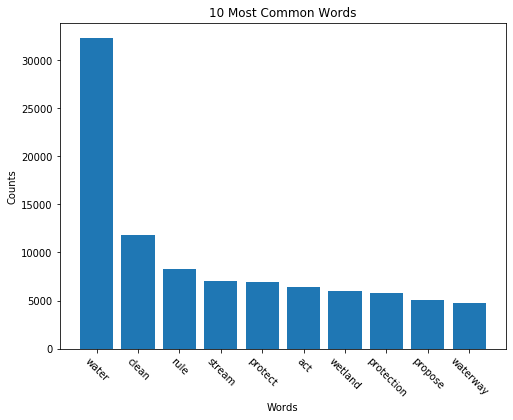

In [22]:
# Visualize 10 most common words
plot_most_common_words(count_data, count_vec)

## Topic Analysis

### Word Cloud - Full Training Set of Comments

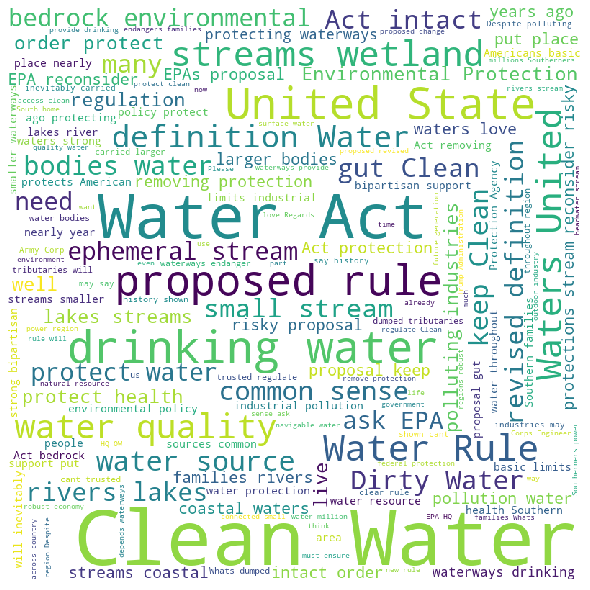

In [23]:
# Combine comments into one "text"
text_all = ' '.join(X_train['Comment'])

wordcloud_all = WordCloud(width = 800,
                          height = 800, 
                          background_color ='white',
                          min_font_size = 10).generate(text_all)

# Plot the word cloud
plt.figure(figsize = (8, 8), facecolor=None);
plt.imshow(wordcloud_all);
plt.axis("off");
plt.tight_layout(pad=0);
plt.savefig('./Figures/wordcloud_all.png');
plt.show();

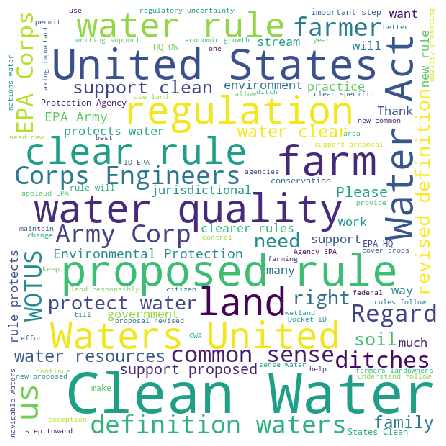

In [24]:
# Word cloud for SUPPORTIVE comments only
support_train = X_labeled_train[y_labeled_train == 1]

text_sup = ' '.join(support_train['Comment'])

wordcloud_sup = WordCloud(width = 600,
                          height = 600, 
                          background_color ='white',
                          min_font_size = 10).generate(text_sup)

# Plot the word cloud
plt.figure(figsize = (6, 6), facecolor=None);
plt.imshow(wordcloud_sup);
plt.axis("off");
plt.tight_layout(pad=0);
plt.savefig('./Figures/wordcloud_sup.png');
plt.show();

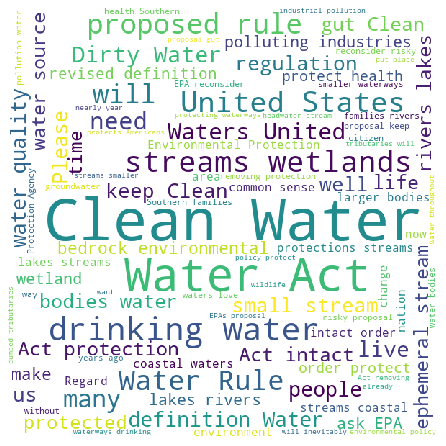

In [25]:
# Word cloud for OPPOSING comments only
oppose_train = X_labeled_train[y_labeled_train == 0]

text_opp = ' '.join(oppose_train['Comment'])

wordcloud_opp = WordCloud(width = 600,
                          height = 600, 
                          background_color ='white',
                          min_font_size = 10).generate(text_opp)

# Plot the word cloud
plt.figure(figsize = (6, 6), facecolor=None);
plt.imshow(wordcloud_opp);
plt.axis("off");
plt.tight_layout(pad=0);
plt.savefig('./Figures/wordcloud_opp.png');
plt.show();

### Singular Value Decomposition (SVD) Analysis

In [121]:
# Run SVD to create topic matrices
U, s, Vh = linalg.svd(count_data.todense(), full_matrices=False)
print(U.shape, s.shape, Vh.shape)

(6388, 4144) (4144,) (4144, 4144)


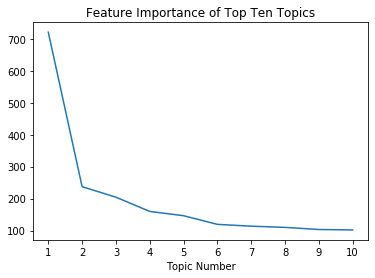

In [122]:
# Plot s to see where topic importance drops off
plt.plot(range(1, 11), s[:10]);
plt.xticks(range(1, 11));
plt.xlabel('Topic Number');
plt.title('Feature Importance of Top Ten Topics');

In [123]:
# Print top 10 topics
show_topics(Vh[:10], vocab)

['selfishness 0149please gracious communist rotational humble tyranny ward',
 'clean waterway act family proposal industry drink protect',
 'stream wetland downstream flow small headwater river fish',
 'water park protection quality wetland state change unite',
 'definition state waterway unite provide wotus tributary ephemeral',
 'waterway propose clean protection act community dirty polluter',
 'state definition downstream water unite community river dirty',
 'waterway new clear leave definition polluter farmer ephemeral',
 'epa community wetland family definition safeguard instead health',
 'propose water definition wotus park flow support body']

The first topic contains some curveballs (which call into question running SVD analysis directly like this), however the other topics seem to reasonably fit the core themes in the public comments.

### LDA

Latent Dirichlet Allocation (LDA) is a statistical model that finds the different mix of `n_components` topics that explain each comment. Comparing the perplexity metric of different numbers of topics is a quantitative way to help determine the appropriate number.

Per [Wikipedia's article on perplexity](https://en.wikipedia.org/wiki/Perplexity):

>In information theory, **perplexity** is a measurement of how well a probability distribution or probability model predicts a sample. It may be used to compare probability models. A low perplexity indicates the probability distribution is good at predicting the sample. 

LDA analysis had much higher perplexity scores (~10x higher) using the TF-IDF vectorizer vs. the standard count vectorizer, so all analysis below shows the count vectorizer only.

In [26]:
# Compare perplexity scores to find optimal number of topics
p = []

print('-'*30)
for n in range(2, 23, 2):
    mod = LDA(n_components=n,
              n_jobs=-1,
              random_state=42)
    mod.fit(count_data)
    p.append(mod.bound_)
    print('Number of Topics: {}'.format(n))
    print('Perplexity score: {0:,.0f}'.format(mod.bound_))
    print('-'*30)

------------------------------
Number of Topics: 2
Perplexity score: 581
------------------------------
Number of Topics: 4
Perplexity score: 524
------------------------------
Number of Topics: 6
Perplexity score: 503
------------------------------
Number of Topics: 8
Perplexity score: 480
------------------------------
Number of Topics: 10
Perplexity score: 474
------------------------------
Number of Topics: 12
Perplexity score: 474
------------------------------
Number of Topics: 14
Perplexity score: 465
------------------------------
Number of Topics: 16
Perplexity score: 461
------------------------------
Number of Topics: 18
Perplexity score: 464
------------------------------
Number of Topics: 20
Perplexity score: 462
------------------------------
Number of Topics: 22
Perplexity score: 459
------------------------------


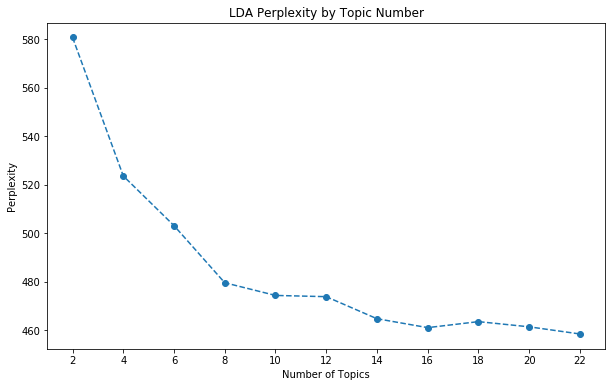

In [27]:
# Plot the perplexity scores
xtick = list(range(2, 23, 2))

plt.figure(figsize=(10, 6));
plt.xticks(xtick);
plt.plot(xtick, p, 'o--', c='#1f78b4');
plt.title('LDA Perplexity by Topic Number');
plt.ylabel('Perplexity');
plt.xlabel('Number of Topics');
# plt.savefig('./Figures/LDA_Perplexity_for_nTopics.png');
plt.show();

The sharpest decline in perplexity score happens from two to eight topics, with a flattening out thereafter. As lower perplexity scores are better but increasing the number of topics will generally keep reducing the metric, this is a case where the "elbow" method can be applied. The chart indicates that around 8 topics is where the law of diminishing returns kicks in. The next step is to review the topics qualitatively to determine if they fit the dataset.

While there's overlap in the language of several topics (see below), there's one clear topic for supportive comments while the rest seem to highlight different reasons to oppose it. Given the ratio of around 20% supportive comments in the corpus, 1-2 topics would be representative.

In [28]:
# Analyze output using 8 topics
n_topics = 8

lda = LDA(n_components=n_topics,
          n_jobs=-1,
          random_state=42)

lda.fit(count_data)  # TF-IDF had much higher overall perplexity scores

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=8, n_jobs=-1,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [31]:
lda.components_.shape

(8, 4144)

In [32]:
print('Final perplexity score using {0} topics: {1:,.0f}'
      .format(n_topics, lda.bound_))  # TF-IDF perplexity: 2,698

Final perplexity score using 8 topics: 480


In [33]:
print('Top words for each topic:\n')

show_topics(lda.components_, vocab, 10)

Top words for each topic:



['water stream wetland clean rule protect downstream propose river flow',
 'water waterway clean rule act propose wetland protection protect state',
 'water rule farmer clean clear support propose epa land farm',
 'water wetland state definition propose protection change stream unite rule',
 'water clean protect people need regulation environment life live right',
 'water wetland clean protection park stream quality waterway propose rule',
 'water clean act protect waterway river stream drink proposal family',
 'water clean rule act community protection dirty epa propose polluter']

In [34]:
# Create pipeline to process raw text of test comments
lda_count_pipe = make_pipeline(count_vec, lda)

In [35]:
# Check a test comment for most likely topic
comment_1 = X_train.loc[187, 'Comment']
print(comment_1)

I support the revised clean water act rule. The fact is that farmers and ranchers take better care of our land, and water. We do not need to put unnecessary government restrictions on people who are already doing the right thing. Just so the government can be more controlling, and more money hungry with permits etc. I am a fifth generation Texas rancher, my land, and my water. My grandfather always said their are two things you can never get back land and water so we need to take care of it, and thats how ranchers and farmers think and treat it.


In [36]:
c_1 = lda_count_pipe.transform([comment_1])
print(c_1[0])
print('Most likely topic: {} (using zero-based indexing)'.format(c_1.argmax()))

[0.00284316 0.00284255 0.47862839 0.00284351 0.43714256 0.002844
 0.07000895 0.00284688]
Most likely topic: 2 (using zero-based indexing)


In [45]:
# Check another test comment for most likely topic
comment_2 = X_train.loc[5514, 'Comment']
print(comment_2)

Please do not weakening the Clean Water Act (CWA) by narrowing the definition of the Waters of the United States.  One justification for the proposed redefinition of the Waters of the United States to exclude huge volumes of ground water and the many ephemeral waters scatters across the US is said to be economic growth.  Industrial development in or on wetlands might result in short term economic benefits for the developers or the users.  However, anytime a wetland is lost to developers, the services that wetland provides free of charge are lost forever. Precipitation that was once filtered and purified on its way into watershed groundwater becomes floodwater that flushes parking lots, loading dock aprons, driveways, streets, roofs, whatever is stored outside, and residues of whatever may be exposed at those locations  as well as, lawn fertilizers and pesticides used on what little landscape remains green.  So, a few people make short term profits while everyone who lives further downh

In [46]:
c_2 = lda_count_pipe.transform([comment_2])
print(c_2[0])
print('Most likely topic: {} (using zero-based indexing)'.format(c_2.argmax()))

[0.00097982 0.00097788 0.00097781 0.80490169 0.08943119 0.10077409
 0.00097856 0.00097897]
Most likely topic: 3 (using zero-based indexing)


In [135]:
# Visualize the Topics
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda, count_data, count_vec, mds='tsne')
panel

/Users/heatherkusmierz/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
3     -108.958252 -208.941483       1        1  23.058578
6      186.487061  -98.103249       2        1  17.213258
2       19.245832  160.858780       3        1  13.233871
7      170.658829   75.445076       4        1  11.625292
0       -1.386411  -35.043739       5        1  11.324209
4     -145.800095  106.944611       6        1  10.092675
5       64.834541 -221.825272       7        1   8.114666
1     -196.906036  -58.990913       8        1   5.337451, topic_info=     Category          Freq       Term         Total  loglift  logprob
3249  Default   8136.000000       rule   8136.000000  30.0000  30.0000
4065  Default   5924.000000    wetland   5924.000000  29.0000  29.0000
4040  Default   4703.000000   waterway   4703.000000  28.0000  28.0000
3557  Default   6977.000000     stream   6977.000000  27.0000  27.0000
4033  Default  31920.000000      water  31920.000000  26.0000  26.0000
...       ...           ...        ...           ...      ...      ...
1377   Topic8    204.870867  ephemeral   1246.288009   1.1249  -4.8062
1590   Topic8    187.328604       flow   1704.519859   0.7222  -4.8957
2996   Topic8    191.016637    quality   2178.699439   0.4963  -4.8762
1240   Topic8    181.247678      drink   3279.898315   0.0347  -4.9287
719    Topic8    153.068823    citizen    735.034604   1.3614  -5.0977

[654 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
8         3  0.977156       0149to
24        1  0.018049           18
24        5  0.806205           18
24        7  0.174477           18
48        1  0.955154         2008
...     ...       ...          ...
4135      7  0.990444  yellowstone
4136      2  0.058202          yes
4136      5  0.058202          yes
4136      6  0.873025          yes
4139      5  0.988043        yorks

[1868 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 7, 3, 8, 1, 5, 6, 2])

In [158]:
# pyLDAvis.save_html(panel, './pyLDAvis.html')

The comments in the dataset tend to share a lot of language, so the most frequent words show up in many of the topics. This makes it hard to distinguish the topics with top words alone. After adjusting the relevance metric slide to reduce $\lambda$, the general themes (and differences between) the topics became more clear. Below is a general summary the key words per topic:

<ol>
    <li>Commenters making science-themed arguments that relate to definitions and exclusions in the rule change, like navigable waters, groundwater, ephemeral streams, intermittent streams, surface water, and the connectedness of the water system in general. They also argue for wildlife</li>
    <li>Commenters using their regional experiences (particularly in the south and west) to request a reconsideration of the "risky" proposal. They note that the CWA is a bipartisan success story and should remain intact</li>
    <li>Farmers and ranchers supporting "clean water and clear (or common-sense) rules". Also includes landowners pushing for property rights. These are people who mention they are using responsible farming techniques on their land and want clarity on what waterways are federally regulated</li>
    <li>Commenters opposing the proposed "dirty water" rule by noting the environmental threats like pollution and health and safety issues when regulations are loosened. They request the EPA abandon the dangerous rollback of the CWA</li>
    <li>Commenters making environmental arguments about the importance of headwater, the risk to downstream users when there's water issues, and that we need to continuously protect water using available science</li>
    <li>Commenters saying clean water is a right and necessity in life, we all need it to live, and the government and its bureaucrats are responsible for protecting it. Also, people need to look to the future to see what we're leaving to our children</li>
    <li>Commenters making arguments that the rule change will diminish outdoor recreation experiences and can affect parks, nature, and wildlife. Also argues to protect arid locations</li>
    <li>Commenters making arguments to protect temporary waterways and ephemeral streams, with mentions of Western states, and that the new rule will leave these waterways unprotected</li>
  </ol>

### NMF

In [41]:
# Create and fit an NMF model with count vectorizer
nmf = NMF(n_components=n_topics,
          random_state=42)

W1 = nmf.fit_transform(count_data)
H1 = nmf.components_

In [42]:
print(W1.shape)
print(H1.shape)

(6388, 8)
(8, 4144)


In [43]:
show_topics(H1, vocab, 10)

['water clean act protect river pollution need protection live lake',
 'rule water farmer farm epa protect clear land corp new',
 'stream wetland downstream rule flow propose protect headwater small river',
 'waterway protect stream water proposal family act drink industry region',
 'water clean rule community waterway dirty epa polluter safeguard family',
 'water state definition unite wetland change ephemeral protection stream waterway',
 'protection park wetland water quality stream waterway propose country change',
 'rule propose wotus support epa case protection 2015 agency definition']

In [44]:
# Test cosine similarity - normalize features
norm_feats = normalize(W1)

In [48]:
# Find cosine similarity of test_comment to all others
sim_df = pd.DataFrame(norm_feats, index=X_train['Comment'])
sim_df.head()

,0,1,2,3,4,5,6,7
Comment,,,,,,,,
S. Waters- I live on the Rappahannock River. I'm concerned this proposed rule would remove protections that impact overall water quality. I rely on this as a source of my drinking water. All this could be harmed by the loss of federal protections. I ask the EPA to keep the Clean Water Act intact.,0.623954,0.000000,0.000000,0.142480,0.000000,0.000000,0.428366,0.637874
"economy.I am writing in hopes that my words will reach someone who cares about the health of people and life in general. I was shocked to hear the proposal to limit the Clean Water Act. My family & I live on a beautiful lake & regularly fish, swim & kayak in our lake & small streams. Why on earth would people even consider the polluting of our waterways to be acceptable? It just doesnt make any sense. There is obviously money involved. Someone stands to make a profit by allowing this change. This proposal to limit the Clean Water Act must be stopped. We must become better human beings, not worse. We must protect our natural resources if our planet & we are to survive. Regards, Jennifer Haller",0.633846,0.000000,0.179202,0.666047,0.350009,0.000000,0.000000,0.000000
I'd like the cleanest planet possible. Corporations have it easy enough at wrecking our planet for profit,0.438276,0.000000,0.000000,0.000000,0.898840,0.000000,0.000000,0.000000
"Please consider the importance of our wetlands, the overbuilding already done, the damage seen when we have heavy rains, the pollution flooding into our waterways without the cushion of the wetlands. We are loosing small insects, fish and mammals to extinction at an alarming rate and at a scale we have never seen before. These small animals and amphibians may seem unimportant. But if we can't keep the tiny frogs alive, we're next, on the extinction scale. Sure not in our lifetime, but what are we leaving the future generations? Do we really need more golf courses that pollute our waterways with the overuse of pesticides and fertilizers? Thank you for listening, Gail Cleveland",0.000000,0.000000,0.597824,0.294753,0.156670,0.000000,0.728822,0.000000
"The proposed rule would eliminate entire categories of waterways from the protections afforded by the Clean Water Act, threatening the water you use to drink, grow your food, fish, and recreate. Categories of excluded waterways include: interstate waters, ephemeral streams or other isolated waters, non-adjacent wetlands, ditches, upland waters, and groundwater.The proposed rule disproportionately impacts the western United States by eliminating the Clean Water Acts protections from most waterways and wetlands in New Mexico, Arizona and Nevada.The proposed rule undermines the science supporting an interconnected watershed approach to protect water quality and riparian habitat. More than half of waterways (60 percent) in the United States are ephemeralmeaning water only flows in these creeks or streams for a portion of the yearbut these waterways contribute significant flows and nutrients to our major rivers.In Arizona, New Mexico, Nevada, Utah, Colorado, and California ephemeral streams make up 81 percent of waterways. These creeks are the headwaters and major tributaries of perennial streams that we rely on to ensure quality water for drinking, recreation and agriculture. Under the proposed rule these waterways would be left unprotected.Important wetlands, those not adjacent to other protected waters, will no longer be protected from being filled or polluted. This leaves vulnerable desert springs, seeps and cinegas that provide essential habitat for imperiled species like the Chiricahua leopard frog, Desert pupfish, the Yaqui chub, Gila topminnow, and many species of springsnails",0.178852,0.084695,0.387551,0.164807,0.367743,0.764614,0.183981,0.172520


In [74]:
def cosine_sim(sim_df, vectorizer, nmf_model, comment, print_info=True):
    """
    :param sim_df: DataFrame of normalized NMF model values
        with comment text as index
    :param vectorizer: vectorizer to convert text to TF matrix to
        process given comment
    :param nmf_model: NMF model to transform given comment
    :param comment: str, the comment to use to find other similar ones
        to in the training set
    :return: prints the nlargest() (the highest cosine value and most similar)
        comments in dataset. Returns the dot product of sim_df and processed
        comment
    """
    pipe = make_pipeline(vectorizer, nmf_model)
    a = pipe.transform([comment])
    a = normalize(a)
    similarities = sim_df.dot(a[0])

    if print_info:
        print('COMMENT TEXT:\n{}'.format(comment))
        print('-'*30)
        print('NORMALIZED TOPIC WEIGHTS:')
        print(pd.Series(a[0]))
        print('-'*30)
        print('MOST SIMILAR COMMENTS IN TRAINING SET')
        print(similarities.nlargest())
    
    return similarities

In [75]:
# Test similarities with a sample comment
sim_test = cosine_sim(sim_df, count_vec, nmf, comment_1)

COMMENT TEXT:
I support the revised clean water act rule. The fact is that farmers and ranchers take better care of our land, and water. We do not need to put unnecessary government restrictions on people who are already doing the right thing. Just so the government can be more controlling, and more money hungry with permits etc. I am a fifth generation Texas rancher, my land, and my water. My grandfather always said their are two things you can never get back land and water so we need to take care of it, and thats how ranchers and farmers think and treat it.
------------------------------
NORMALIZED TOPIC WEIGHTS:
0    0.650941
1    0.759128
2    0.000000
3    0.000000
4    0.000000
5    0.000000
6    0.000000
7    0.000000
dtype: float64
------------------------------
MOST SIMILAR COMMENTS IN TRAINING SET
Comment
I support the revised clean water act rule. The fact is that farmers and ranchers take better care of our land, and water. We do not need to put unnecessary government restr

In [76]:
# Test similarities with a sample comment
sim_test = cosine_sim(sim_df, count_vec, nmf, comment_2)

COMMENT TEXT:
Please do not weakening the Clean Water Act (CWA) by narrowing the definition of the Waters of the United States.  One justification for the proposed redefinition of the Waters of the United States to exclude huge volumes of ground water and the many ephemeral waters scatters across the US is said to be economic growth.  Industrial development in or on wetlands might result in short term economic benefits for the developers or the users.  However, anytime a wetland is lost to developers, the services that wetland provides free of charge are lost forever. Precipitation that was once filtered and purified on its way into watershed groundwater becomes floodwater that flushes parking lots, loading dock aprons, driveways, streets, roofs, whatever is stored outside, and residues of whatever may be exposed at those locations  as well as, lawn fertilizers and pesticides used on what little landscape remains green.  So, a few people make short term profits while everyone who lives

In [81]:
# Test similarities with an unseen comment
_text = X_test.loc[6401, 'Comment']
sim_test = cosine_sim(sim_df, count_vec, nmf, _text)

COMMENT TEXT:
Please protect the waterways, the rivers, the creeks. This is essential. The whole of our growing concerns with the environment is essential for all of us. We in this country should be leaders in this endeavor, and not falling behind and into denial and neglect that seems to be the direction we are going. Please do what is needed to protect these waterways.
------------------------------
NORMALIZED TOPIC WEIGHTS:
0    0.000000
1    0.201416
2    0.119388
3    0.816500
4    0.527736
5    0.000000
6    0.000000
7    0.000000
dtype: float64
------------------------------
MOST SIMILAR COMMENTS IN TRAINING SET
Comment
Your job is to protect the environment and health of the people. Please stop trying to overturn all laws protecting the places we love. If you actually ever paid attention in any earth science class, even as a seven year old, you should be chastened enough to stop this rollback.    0.996008
Just another attempt to allow industry to decimate the environment and ou

In [47]:
# Create and fit an NMF model with TF-IDF vectorizer
nmf_tf = NMF(n_components=n_topics,
             random_state=42)

W1_tf = nmf_tf.fit_transform(tf_data)
H1_tf = nmf_tf.components_

In [48]:
show_topics(H1_tf, vocab)

['wetland stream downstream water flow propose headwater rule',
 'water protect act waterway clean family proposal region',
 'water clean community safeguard dirty instead polluter rule',
 'rule farmer water clear support land new farm',
 'overall protection loss concern harm rappahannock water impact',
 'water unite state dangerous dirty definition revise people',
 'park water clean protection wetland quality country roll',
 'blanket arroyos handout cinegas acequias creek disregard connectivity']

## Clustering Analysis

In [101]:
# Create various options for the word vectorizer
n_feats = 4000
titles = ['Count', 'HashL2', 'HashTFIDF', 'TFIDF']

# Count vectorizer
vect_count = CountVectorizer(stop_words=tokenized_stop_words,
                             tokenizer=spacy_tokenizer,
                             max_df=0.90,
                             min_df=5)

# Hashing vectorizer using L2 norm
vect_hash_L2 = HashingVectorizer(stop_words=tokenized_stop_words,
                                 tokenizer=spacy_tokenizer,
                                 n_features=n_feats,
                                 norm='l2')

# Hashing vectorizer normalized using TF-IDF
hashy = HashingVectorizer(stop_words=tokenized_stop_words,
                          tokenizer=spacy_tokenizer,
                          n_features=n_feats,
                          norm=None)

vect_hash_tfidf = make_pipeline(hashy, TfidfTransformer())

# TF-IDF vectorizer
vect_tfidf = TfidfVectorizer(stop_words=tokenized_stop_words,
                             tokenizer=spacy_tokenizer,
                             max_df=0.90,
                             min_df=5)

all_vects = [vect_count, vect_hash_L2, vect_hash_tfidf, vect_tfidf]

In [104]:
# Collect metrics for all vectorizers for different number of clusters
n_clusters = list(range(2, 13))
km_inertias = {t: [] for t in titles}
km_silhouettes = {t: [] for t in titles}

for title, vect in zip(titles, all_vects):
    X_data = vect.fit_transform(X_train['Comment'])
    for n in n_clusters:
        model = KMeans(n_clusters=n,
                       max_iter=100,
                       n_init=1,
                       n_jobs=-1)
        
        model.fit(X_data)
        km_inertias[title].append(model.inertia_)
        km_silhouettes[title].append(metrics.silhouette_score(X_data, model.labels_, sample_size=1000))

/Users/heatherkusmierz/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [107]:
def plot_cluster_scores(title, inertias, silhouettes):
    """
    Create side-by-side line charts of inertia and silhouette scores for
        clustering model and saves the figure
    :param title: str, the type of vectorizer for the chart title and saved
        file name
    :param inertias: list of inertia scores run over range of clusters
    :param silhouettes: list of silhouette scores run over range of clusters
    :return: None
    """
    plt.subplots(1, 2, figsize=(15, 6))
    clusters = list(range(2, len(inertias) + 2))
    
    # Cluster-inertia plot
    plt.subplot(1, 2, 1)
    plt.plot(clusters, inertias, 'o--', c='#82c6e2')
    plt.xticks(clusters)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia Score')
    plt.title('KMeans: Inertia Score by Cluster Count\n'
              '{} Vectorizer'
              .format(title));

    # Cluster-silhouette score plot
    plt.subplot(1, 2, 2)
    plt.plot(clusters, silhouettes, 'o--', c='#d65f5f')
    plt.xticks(clusters)
    plt.ylim((0, 1))
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('KMeans: Silhouette Score by Cluster Count\n'
              '{} Vectorizer'.format(title));

    plt.savefig('./Figures/KMeans_{}_Inertia-Silhouette.png'
                .format(title));
    plt.show()

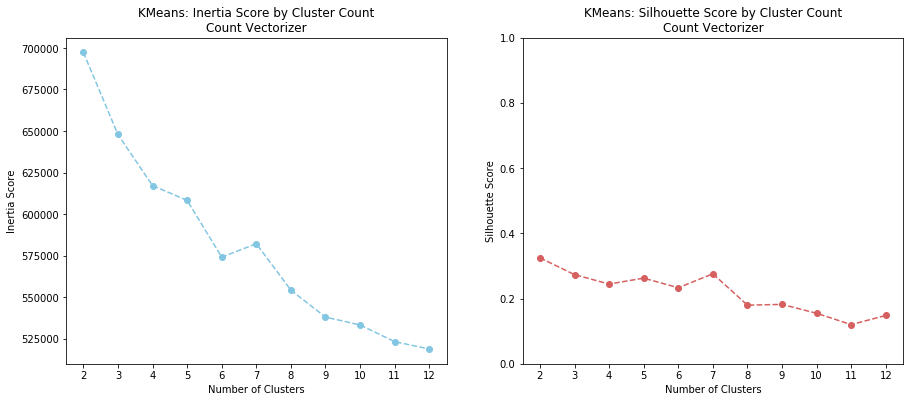

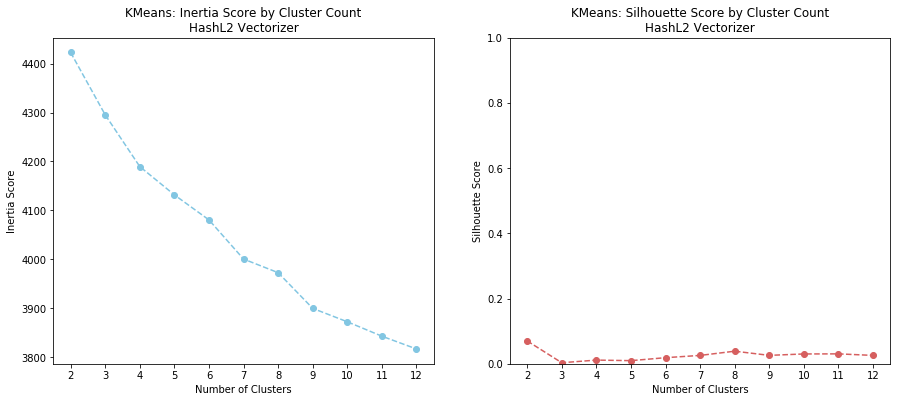

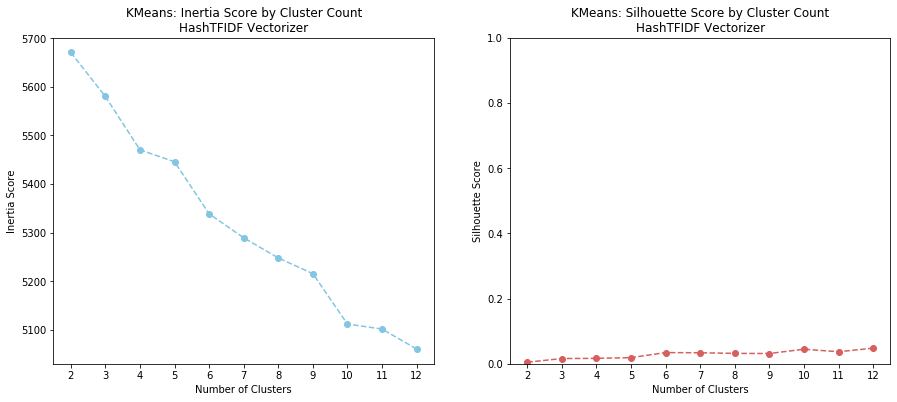

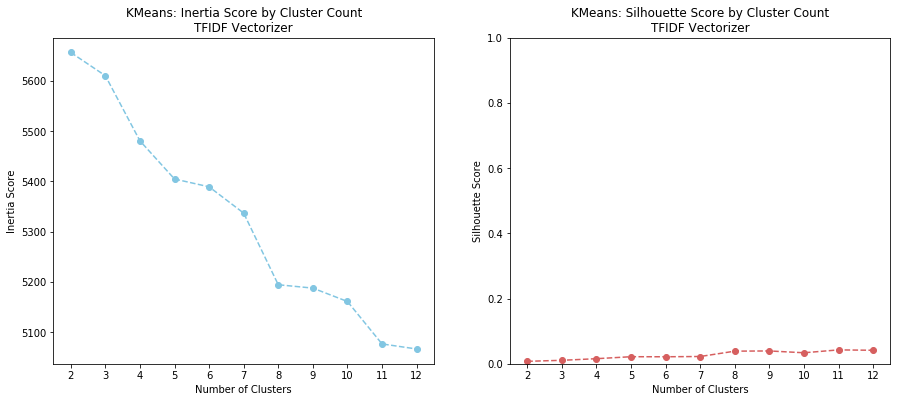

In [108]:
# Plot metrics for all vectorizers
for title in titles:
    plot_cluster_scores(title,
                        km_inertias[title],
                        km_silhouettes[title])

### Summary of Clustering Metrics

**Inertia** calculates the sum of the squared distances between data points and their nearest cluster. Low overall values of inertia are generally better, but it will naturally favor having more clusters.

**Silhouette score** uses two scores to find the mean distance between each observation and all others - both in the same cluster and then in the nearest cluster. Values range from -1 to 1, where a score of 1 indicates the point is close to others in the same cluster, but far away from the next cluster over. A score near -1 indicates the point is not near ones in its cluster but close to the next nearest cluster. And a score of 0 indicates overlapping clusters, where an observation is close to the decision boundary. A score closest to 1 is ideal, as that indicates tight, highly separable clusters.

The KMeans algorithm was run with four different pre-processing applications, then using unigrams only vs. also including bigrams. Including bigrams did not generally improve the metrics, therefore the charts weren't included below.

1) **Count Vectorizer**

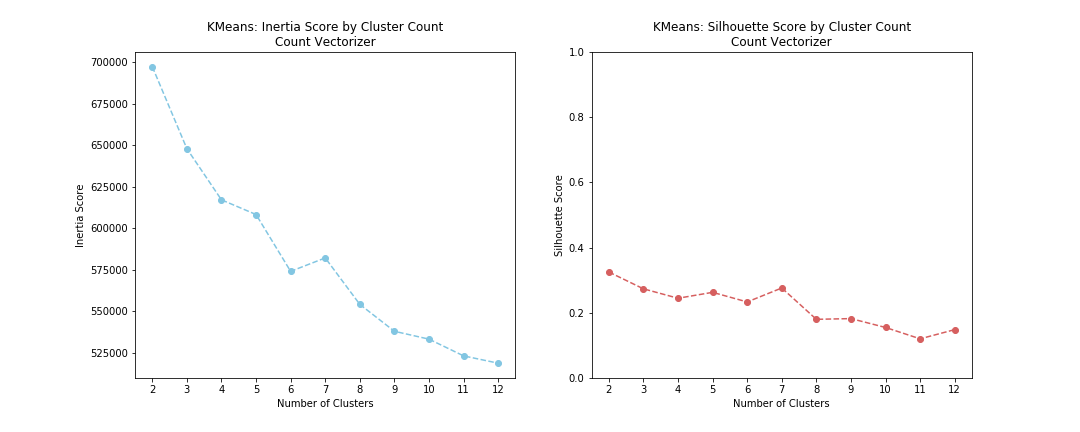

The count vectorizer plots had inertia values that were a factor of over a hundred times higher than all the others, which is why the `y` scale wasn't pegged for them, likely due to the fact those values weren't normalized in any way. It managed the highest overall silhouette scores, though, with the peak value over 0.3 at two clusters.

2) **Hashing Vectorizer with L2 Norm**

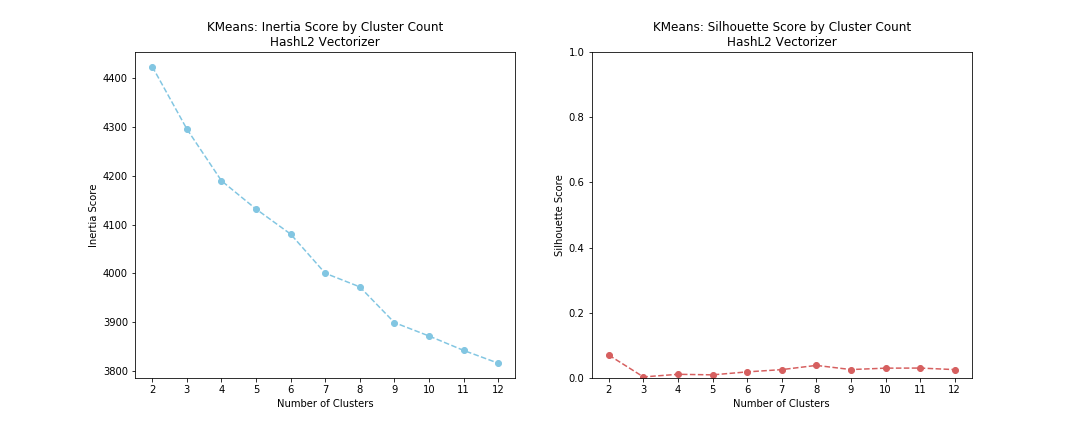

This method had the lowest overall inertia values, but similar silhouette scores as the remaining options.

While the inertia score is the highest for two clusters (as expected), the peak silhouette score favors two clusters. Unfortunately, the silhouette scores are very close to zero, indicating a high degree of overlapping clusters.

3) **Hashing Vectorizer Normalized using TF-IDF**

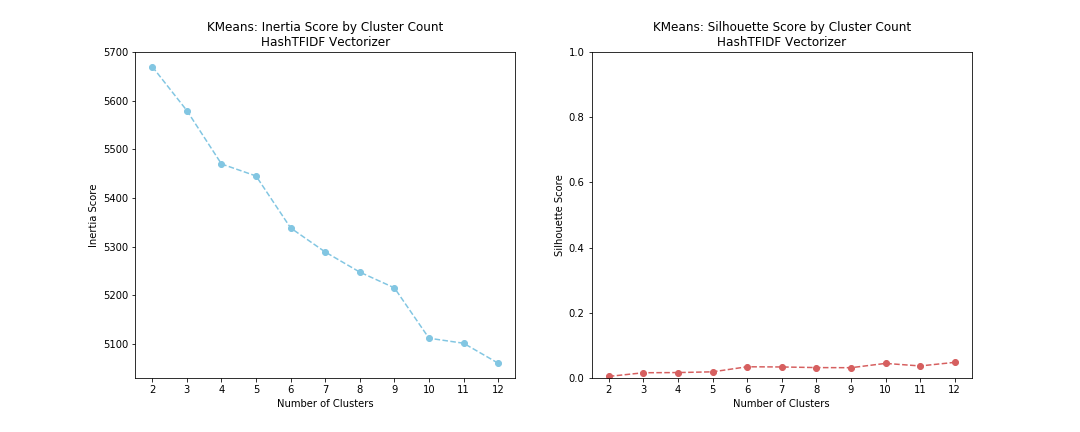

Although a little hard to see given the scale, this analysis shows a story that supports ten clusters. That cluster count has both the near-minimum inertia value as well as the peak silhouette score. However, the overall inertia and silhouette values are worse than the previous analysis using a hashing vectorizer with an L2 norm. The inertia scores are all higher, and the best silhouette score is still below the two-cluster score from that analysis.

4) **TF-IDF Vectorizer**

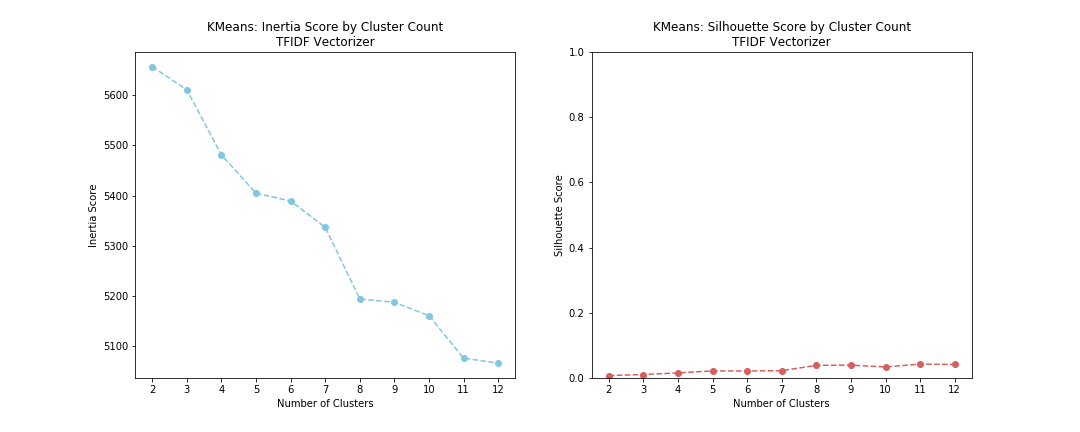

Not surprisingly, this analysis is very similar to the hashing vectorizer with TF-IDF normalization. The overall score values are in line with where they fell out in the other TF-IDF-based analysis. There's no clear optimal number of clusters in these charts, and the silhouette scores seem to continue to climb at the limit of twelve clusters.

In [55]:
# Print comments from cluster 0
cluster_0 = X_train[kmeans.labels_ == 0]

for row in cluster_0.head(20):
    print(row)
    print('\n----------\n')

We da people have da power to send u to Washington with our votes,should be ashamed to take our property rights,may this world find da Lord's mercy especially TV those that abuse da system...!! Regards, William Perez

----------

I am vehemently opposed to the continued (and potential permanent) suspension of the Clean Water Rule.  Water is our most important natural resources.  If we relax our restrictions, we risk additional contamination to our drinking water due to run-off and other problems.  In addition, we need to preserve our non-navigable waterways such as peatland in Wisconsin and surrounding areas, as these result in carbon trapping, further helping to mitigate climate change.  For these and many other scientific reasons, I would ask that the situation be reconsidered.  Please reinstitute the Clean Water Rule.  Thank you for your consideration.

----------

PLEASE WRITE YOUR COMMENT HERE: Fund the Border wall and protect Americans with the border wall, sad that 4,000 America

In [56]:
# Print comments from cluster 1
cluster_1 = X_train[kmeans.labels_ == 1]

for row in cluster_1.head(20):
    print(row)
    print('\n----------\n')

April 15, 2019U.S. Environmental Protection Agency EPA Docket Center Office of Water DocketMail Code 28221T 1200 Pennsylvania Avenue, NWWashington, DC 20460RE:Docket ID No. EPA-HQ-OW-2018-0149To Whom it May Concern:I am a farmer in Champaign county, Illinois. I am writing to submit comments to the United States Environmental Protection Agency (EPA) and the United States Army Corps of Engineers (Corps) in support of the proposal for the revised definition of Waters of the United States under the Clean Water Act.It is time for clear rules that protect both the nations water bodies and farmers ability to produce food, fiber and fuel. This proposed rule would have the ability to end years of uncertainty over where the jurisdiction of EPA and the Corps begins and ends. We need a new common-sense water rule that protects water quality and gives me clear rules I can follow. This new proposed rule would ensure that I dont need a team of lawyers or consultants to tell me what is, and what is no

In [57]:
# Reduce dimensions with PCA
pca = PCA(n_components=50)
components = pca.fit_transform(X_data.todense())
print(pca.explained_variance_ratio_)
sum(pca.explained_variance_ratio_)

[0.18907357 0.06166053 0.03903373 0.02959861 0.02445684 0.01656873
 0.0156257  0.01507728 0.01403607 0.01064842 0.00992414 0.00930263
 0.00823692 0.00744712 0.00696163 0.00666446 0.00576835 0.00552284
 0.00506158 0.00493378 0.00473025 0.00452606 0.00429783 0.00401386
 0.00386101 0.0036893  0.00343043 0.00330445 0.00322912 0.00311173
 0.00301786 0.00288923 0.00274947 0.00269701 0.00256    0.00247283
 0.00233564 0.00229267 0.00225656 0.00219624 0.00212259 0.00211431
 0.00202227 0.00195433 0.00192747 0.00192244 0.00186941 0.00182526
 0.00179185 0.00173657]


0.5685509857389042

In [58]:
components.shape

(6549, 50)

In [59]:
# Re-create DF with labeled clusters
col_names = ['pca_{}'.format(i + 1) for i in range(pca.n_components_)]

pca_df = pd.DataFrame(components, columns=col_names, index=X_train.index)
pca_df['cluster'] = kmeans.labels_

pca_df.head()

,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,pca_11,pca_12,pca_13,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19,pca_20,pca_21,pca_22,pca_23,pca_24,pca_25,...,pca_27,pca_28,pca_29,pca_30,pca_31,pca_32,pca_33,pca_34,pca_35,pca_36,pca_37,pca_38,pca_39,pca_40,pca_41,pca_42,pca_43,pca_44,pca_45,pca_46,pca_47,pca_48,pca_49,pca_50,cluster
3783,-6.988242,-0.078455,0.600188,0.350077,-0.039059,-0.100095,0.314971,-0.132955,0.193868,0.043870,0.154778,0.027457,0.156872,-0.104471,-0.233159,0.009795,-0.114135,0.084342,0.101451,0.035700,-0.061286,0.218991,-0.001577,0.224883,-0.041556,...,0.110649,0.153337,0.192093,0.068443,-0.023449,0.019574,0.122048,-0.068060,-0.201616,-0.011493,-0.310805,0.109872,-0.259468,-0.331251,0.202644,0.081793,-0.028758,-0.069757,0.212003,-0.042302,-0.302175,0.242804,-0.087718,0.144952,0
2110,6.462078,-8.001465,-10.175498,3.889757,-4.805961,6.598756,-2.579382,2.026346,-0.293808,10.941545,-3.557833,1.036633,-0.583799,-2.184234,-0.463617,-1.509382,-3.035718,-0.414488,1.181608,0.633174,-0.761856,-0.729554,-0.909473,-0.597382,-0.603941,...,0.213470,-0.160759,-0.983531,-0.399898,-0.908321,-0.131187,0.070034,0.851135,0.723350,0.123478,-0.266052,0.764590,0.367183,-0.461188,-0.074101,0.039092,-0.182539,-0.063821,0.800885,0.453692,0.059977,0.507568,0.376914,-0.070898,1
2002,22.999196,-2.806202,-0.007386,-1.362399,3.631840,-6.742322,2.653941,-2.355586,-6.258460,-3.510572,-7.434910,2.473976,4.133889,-5.771495,-0.244962,-0.724860,0.951102,-0.327751,6.984431,-1.107209,5.001807,-2.902196,-4.005446,-7.154471,-6.506459,...,2.515759,2.076668,1.495568,-5.093924,1.304104,2.037681,-0.593241,-2.080477,-2.121233,-1.436920,0.832870,-1.911015,1.821039,-1.769203,0.830039,2.588724,-0.451737,-0.842425,2.051593,-1.006513,-0.409824,0.470390,0.189208,-1.542436,1
3047,9.265578,10.887132,-1.702740,3.774142,0.497497,-1.281987,0.280988,-0.437513,0.751648,1.271604,0.093942,1.691504,1.875712,-0.800702,-0.454775,-0.954100,0.623204,0.563777,-0.344089,-0.253963,0.798611,0.869094,0.375097,-0.261906,-0.070279,...,0.458399,-0.642559,0.155177,0.465677,1.033349,-0.196134,0.158975,-0.406901,-0.496486,0.347800,-0.397277,0.202857,-1.032860,0.409442,0.231945,-0.006079,-0.938441,1.385878,0.239827,0.126827,-0.756501,0.795273,0.725711,0.330611,1
418,-2.275249,-0.315430,-0.279999,-1.289857,-0.402762,0.411919,0.051670,0.337858,-0.286024,-0.712471,0.397320,-0.912491,0.713092,0.395776,0.657970,0.037492,-0.526134,0.468666,-0.151019,-0.183802,-0.857933,-0.015376,-0.579456,-0.528356,-0.171127,...,-0.289701,0.241652,-0.058237,0.150081,0.368532,-0.771357,-0.588163,-0.254433,-0.063201,0.029593,-0.144006,-0.357068,0.660576,0.892020,0.055577,0.245766,0.293930,-0.689665,0.315957,-0.097251,0.273067,0.248618,-0.120362,-0.148678,0


In [60]:
# Read in labeled comment sample
labels = pd.read_excel('./Data/comments_labeled.xlsx',
                       header=0,
                       index_col=0,
                       usecols=[0, 2])

labels.dropna(inplace=True)  # only keep labeled samples
labels.shape

(202, 1)

In [61]:
samples = pd.merge(labels, pca_df[['pca_1', 'pca_2']],
                   left_index=True,
                   right_index=True)

samples.tail(10)

,Support_Rule_Change,pca_1,pca_2
193,0.0,-1.780858,1.021935
194,0.0,5.606051,2.048253
195,1.0,-6.315131,-0.122651
196,0.0,-5.468302,-0.555857
197,1.0,-1.880429,-0.100075
200,0.0,-2.376351,2.792487
201,0.0,-2.621916,-2.668467
202,0.0,-3.562538,0.408654
203,0.0,-3.232154,0.679567
204,0.0,1.049201,0.223553


In [62]:
samples.shape

(157, 3)

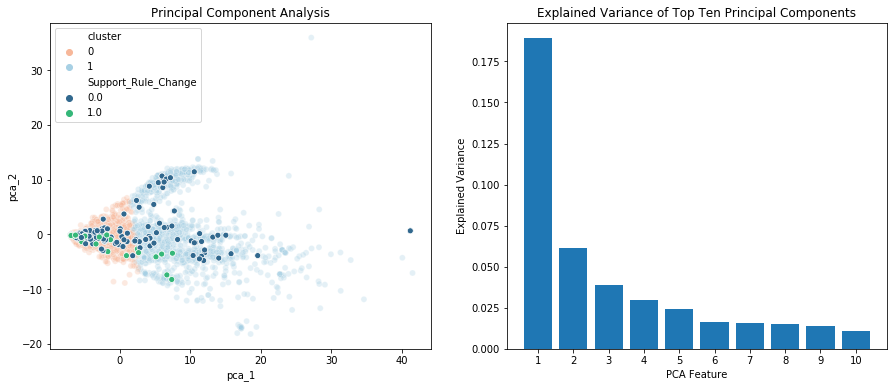

In [63]:
# Plot first two principal components and explained variance
plt.subplots(1, 2, figsize=(15, 6));
plt.subplot(1, 2, 1);
sns.scatterplot(x='pca_1', y='pca_2', data=pca_df, hue='cluster', alpha=0.3, palette='RdBu');
sns.scatterplot(x='pca_1', y='pca_2', data=samples, hue='Support_Rule_Change', palette='viridis')
plt.title('Principal Component Analysis');

feats = range(1, 11)
plt.subplot(1, 2, 2);
plt.bar(feats, pca.explained_variance_ratio_[:10]);
plt.xticks(feats);
plt.xlabel('PCA Feature');
plt.ylabel('Explained Variance');
plt.title('Explained Variance of Top Ten Principal Components');

plt.savefig('./Figures/PCA_{}{}Lemma.png'.format(chart_title, 'Bigrams' if use_bigrams else ''));

In [64]:
# TSNE cluster visualization
tsne = TSNE(n_components=2, perplexity=30)
tsne_res = tsne.fit_transform(X_data)

In [65]:
tsne_res.shape

(6549, 2)

In [66]:
# Re-create DF with TSNE results
tsne_df = pd.DataFrame(tsne_res, columns=['tsne_1', 'tsne_2'], index=X_train.index)
tsne_df['cluster'] = kmeans.labels_

tsne_df.head()

,tsne_1,tsne_2,cluster
3783,2.090433,32.460896,0
2110,53.777203,-4.799178,1
2002,-32.537228,-19.469563,1
3047,17.175196,-40.237095,1
418,11.572308,8.600972,0


In [67]:
# Create TSNE sample DF
tsne_samples = pd.merge(labels, tsne_df[['tsne_1', 'tsne_2']],
                        left_index=True,
                        right_index=True)

tsne_samples.tail(10)

,Support_Rule_Change,tsne_1,tsne_2
193,0.0,-0.623096,-4.700883
194,0.0,12.200483,-25.251297
195,1.0,-15.212007,29.088776
196,0.0,-3.692414,-61.038021
197,1.0,0.332374,-3.210941
200,0.0,9.080447,-18.058332
201,0.0,-9.154532,26.201662
202,0.0,4.708173,7.525336
203,0.0,3.286972,-4.547688
204,0.0,-4.220626,-8.533299


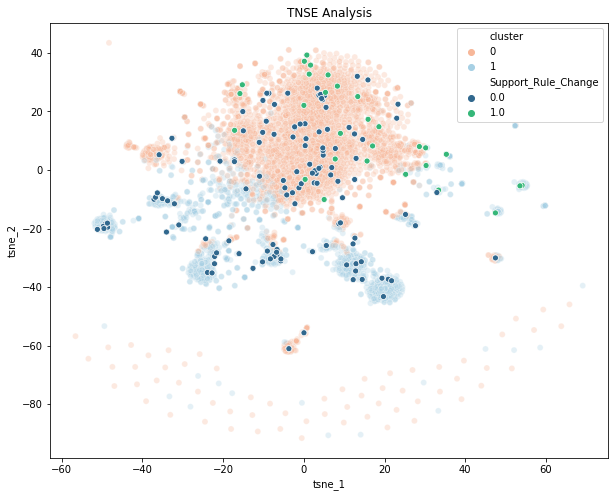

In [68]:
# Plot the TSNE results
plt.figure(figsize=(10, 8));
sns.scatterplot(x='tsne_1', y='tsne_2', data=tsne_df, hue='cluster', alpha=0.3, palette='RdBu');
sns.scatterplot(x='tsne_1', y='tsne_2', data=tsne_samples, hue='Support_Rule_Change', palette='viridis');
plt.title('TNSE Analysis');
plt.savefig('./Figures/TSNE_{}{}Lemma.png'.format(chart_title, 'Bigrams' if use_bigrams else ''))